## Introduction Example Plots

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import hessenberg, qr, eig
import time
from typing import List, Tuple
import pandas as pd
import math
from IPython.display import display, Markdown
from ast import literal_eval
import re

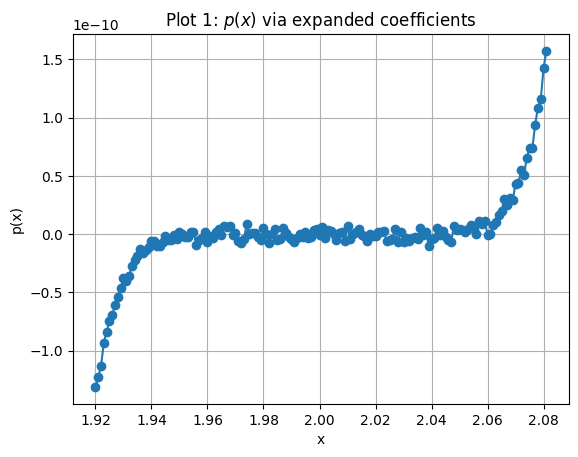

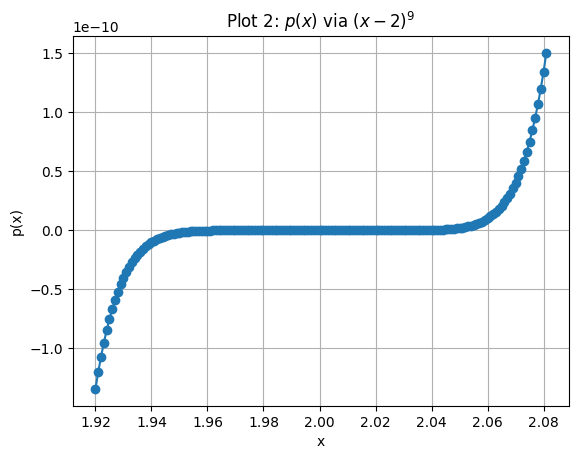

In [30]:
x = np.arange(1.920, 2.081, 0.001)
coeffs = [1, -18, 144, -672, 2016, -4032, 5376, -4608, 2304, -512]

y_coeff = np.polyval(coeffs, x)

y_factored = (x - 2.0) ** 9

plt.figure()
plt.plot(x, y_coeff, marker='o', linestyle='-')
plt.title("Plot 1: $p(x)$ via expanded coefficients")
plt.xlabel("x")
plt.ylabel("p(x)")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(x, y_factored, marker='o', linestyle='-')
plt.title("Plot 2: $p(x)$ via $(x-2)^9$")
plt.xlabel("x")
plt.ylabel("p(x)")
plt.grid(True)
plt.show()

## The Hessenberg Reduction Function (1a)

In [31]:
def build_householder_unit_vector(
        target_vector: np.ndarray
) -> np.ndarray:
    
    """
    Builds a Householder unit vector

    Args:
        1. target_vector (np.ndarray): Column vector that we want to annihilate (size ≥ 1).

    Returns:
        np.ndarray:
            The normalised Householder vector (‖v‖₂ = 1) with a real first component.

    Raises:
        1. ValueError: If 'target_vector' has zero length.
    """

    if target_vector.size == 0:
        raise ValueError("The target vector is empty; no reflector needed.")

    vector_norm: float = np.linalg.norm(target_vector)

    if vector_norm == 0.0: #nothing to annihilate – return canonical basis vector
        householder_vector: np.ndarray = np.zeros_like(target_vector)
        householder_vector[0] = 1.0
        return householder_vector

    sign_correction: float = (
        1.0 if target_vector[0].real >= 0.0 else -1.0
    )
    copy_of_target_vector: np.ndarray = target_vector.copy()
    copy_of_target_vector[0] += sign_correction * vector_norm
    householder_vector: np.ndarray = (
        copy_of_target_vector / np.linalg.norm(copy_of_target_vector)
    )
    return householder_vector


def to_hessenberg(
        original_matrix: np.ndarray,
) -> Tuple[List[np.ndarray], np.ndarray, np.ndarray]:
    
    """
    Reduce 'original_matrix' to upper Hessenberg form by Householder reflections.

    Args
        1. original_matrix (np.ndarray): Real or complex square matrix of order 'matrix_order'.

    Returns
        Tuple consisting of:

        1. householder_reflectors_list (List[np.ndarray])
        2. hessenberg_matrix (np.ndarray)
        3. accumulated_orthogonal_matrix (np.ndarray)  s.t.
          original_matrix = Q · H · Qᴴ

    Raises
        1. ValueError: If 'original_matrix' is not square.
    """

    working_matrix: np.ndarray = np.asarray(original_matrix).copy()

    if working_matrix.shape[0] != working_matrix.shape[1]:
        raise ValueError("Input matrix must be square.")

    matrix_order: int = working_matrix.shape[0]
    accumulated_orthogonal_matrix: np.ndarray = np.eye(
        matrix_order, dtype=working_matrix.dtype
    )
    householder_reflectors_list: List[np.ndarray] = []

    for column_index in range(matrix_order - 2): #extract the part of column 'column_index' that we want to zero out
        target_column_segment: np.ndarray = working_matrix[
            column_index + 1 :, column_index
        ]

        householder_vector: np.ndarray = build_householder_unit_vector(
            target_column_segment
        )  #build Householder vector for this segment
        householder_reflectors_list.append(householder_vector)

        #expand it to the full matrix dimension
        expanded_householder_vector: np.ndarray = np.zeros(
            matrix_order, dtype=working_matrix.dtype
        )
        expanded_householder_vector[column_index + 1 :] = householder_vector


        working_matrix -= 2.0 * np.outer( 
            expanded_householder_vector,
            expanded_householder_vector.conj().T @ working_matrix,
        ) #apply reflector from BOTH sides
        working_matrix -= 2.0 * np.outer(
            working_matrix @ expanded_householder_vector,
            expanded_householder_vector.conj().T,
        )

        #accumulate Q
        accumulated_orthogonal_matrix -= 2.0 * np.outer(
            accumulated_orthogonal_matrix @ expanded_householder_vector,
            expanded_householder_vector.conj().T,
        )

    hessenberg_matrix: np.ndarray = working_matrix
    return (
        householder_reflectors_list,
        hessenberg_matrix,
        accumulated_orthogonal_matrix,
    )


## Evaluating the Hessenberg Reduction Function (1b)


**64×64 general**  
<span style='color:green'>‖A − Q T Qᵀ‖ = 8.03e-14</span>  
‖QᵀQ − I‖ = 7.67e-15

**64×64 symmetric**  
<span style='color:green'>‖A − Q T Qᵀ‖ = 4.78e-14</span>  
‖QᵀQ − I‖ = 7.32e-15

**128×128 general**  
<span style='color:green'>‖A − Q T Qᵀ‖ = 1.80e-13</span>  
‖QᵀQ − I‖ = 1.24e-14

**128×128 symmetric**  
<span style='color:green'>‖A − Q T Qᵀ‖ = 1.13e-13</span>  
‖QᵀQ − I‖ = 1.25e-14

**192×192 general**  
<span style='color:green'>‖A − Q T Qᵀ‖ = 3.09e-13</span>  
‖QᵀQ − I‖ = 1.76e-14

**192×192 symmetric**  
<span style='color:green'>‖A − Q T Qᵀ‖ = 1.91e-13</span>  
‖QᵀQ − I‖ = 1.75e-14

**256×256 general**  
<span style='color:green'>‖A − Q T Qᵀ‖ = 4.53e-13</span>  
‖QᵀQ − I‖ = 2.27e-14

**256×256 symmetric**  
<span style='color:green'>‖A − Q T Qᵀ‖ = 2.97e-13</span>  
‖QᵀQ − I‖ = 2.38e-14

**320×320 general**  
<span style='color:green'>‖A − Q T Qᵀ‖ = 6.07e-13</span>  
‖QᵀQ − I‖ = 2.72e-14

**320×320 symmetric**  
<span style='color:green'>‖A − Q T Qᵀ‖ = 3.76e-13</span>  
‖QᵀQ − I‖ = 2.71e-14

**384×384 general**  
<span style='color:green'>‖A − Q T Qᵀ‖ = 7.78e-13</span>  
‖QᵀQ − I‖ = 3.11e-14

**384×384 symmetric**  
<span style='color:green'>‖A − Q T Qᵀ‖ = 4.71e-13</span>  
‖QᵀQ − I‖ = 3.16e-14

**448×448 general**  
<span style='color:green'>‖A − Q T Qᵀ‖ = 9.35e-13</span>  
‖QᵀQ − I‖ = 3.50e-14

**448×448 symmetric**  
<span style='color:green'>‖A − Q T Qᵀ‖ = 5.93e-13</span>  
‖QᵀQ − I‖ = 3.72e-14

**512×512 general**  
<span style='color:green'>‖A − Q T Qᵀ‖ = 1.16e-12</span>  
‖QᵀQ − I‖ = 4.13e-14

**512×512 symmetric**  
<span style='color:green'>‖A − Q T Qᵀ‖ = 7.14e-13</span>  
‖QᵀQ − I‖ = 4.13e-14

**576×576 general**  
<span style='color:green'>‖A − Q T Qᵀ‖ = 1.38e-12</span>  
‖QᵀQ − I‖ = 4.54e-14

**576×576 symmetric**  
<span style='color:green'>‖A − Q T Qᵀ‖ = 8.39e-13</span>  
‖QᵀQ − I‖ = 4.56e-14

**640×640 general**  
<span style='color:green'>‖A − Q T Qᵀ‖ = 1.58e-12</span>  
‖QᵀQ − I‖ = 4.93e-14

**640×640 symmetric**  
<span style='color:green'>‖A − Q T Qᵀ‖ = 9.77e-13</span>  
‖QᵀQ − I‖ = 5.07e-14

**704×704 general**  
<span style='color:green'>‖A − Q T Qᵀ‖ = 1.81e-12</span>  
‖QᵀQ − I‖ = 5.41e-14

**704×704 symmetric**  
<span style='color:green'>‖A − Q T Qᵀ‖ = 1.08e-12</span>  
‖QᵀQ − I‖ = 5.35e-14

**768×768 general**  
<span style='color:green'>‖A − Q T Qᵀ‖ = 2.05e-12</span>  
‖QᵀQ − I‖ = 5.92e-14

**768×768 symmetric**  
<span style='color:green'>‖A − Q T Qᵀ‖ = 1.25e-12</span>  
‖QᵀQ − I‖ = 5.98e-14

**832×832 general**  
<span style='color:green'>‖A − Q T Qᵀ‖ = 2.29e-12</span>  
‖QᵀQ − I‖ = 6.32e-14

**832×832 symmetric**  
<span style='color:green'>‖A − Q T Qᵀ‖ = 1.38e-12</span>  
‖QᵀQ − I‖ = 6.28e-14

**896×896 general**  
<span style='color:green'>‖A − Q T Qᵀ‖ = 2.53e-12</span>  
‖QᵀQ − I‖ = 6.71e-14

**896×896 symmetric**  
<span style='color:green'>‖A − Q T Qᵀ‖ = 1.50e-12</span>  
‖QᵀQ − I‖ = 6.65e-14

**960×960 general**  
<span style='color:green'>‖A − Q T Qᵀ‖ = 2.78e-12</span>  
‖QᵀQ − I‖ = 7.14e-14

**960×960 symmetric**  
<span style='color:green'>‖A − Q T Qᵀ‖ = 1.68e-12</span>  
‖QᵀQ − I‖ = 7.19e-14

**1024×1024 general**  
<span style='color:green'>‖A − Q T Qᵀ‖ = 3.09e-12</span>  
‖QᵀQ − I‖ = 7.71e-14

**1024×1024 symmetric**  
<span style='color:green'>‖A − Q T Qᵀ‖ = 1.84e-12</span>  
‖QᵀQ − I‖ = 7.53e-14

size,type,reps,avg
64,general,200,3.675e-03
64,symmetric,325,3.042e-03
128,general,84,1.215e-02
128,symmetric,128,7.681e-03
192,general,32,3.234e-02
192,symmetric,55,1.946e-02
256,general,14,7.898e-02
256,symmetric,27,3.648e-02
320,general,8,1.349e-01
320,symmetric,16,6.274e-02


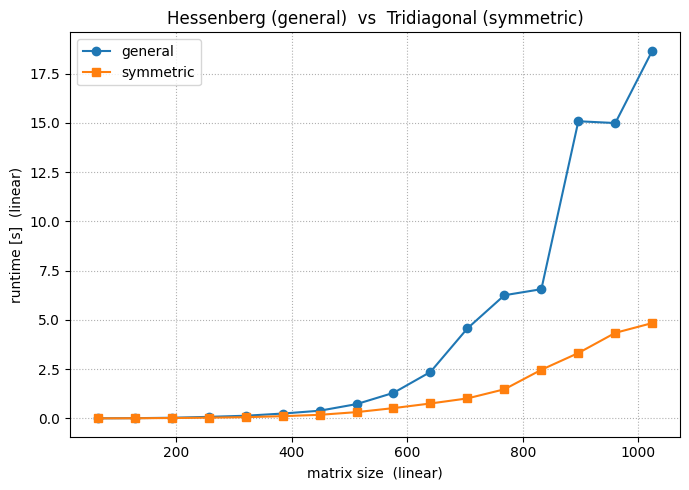

In [32]:
#RANDOM MATRIX GENERATOR
def generate_random_matrix(n:int, distribution:str="normal",
                           symmetric:bool=False, seed:int|None=None):
    rng = np.random.default_rng(seed)
    if distribution == "normal":
        A = rng.standard_normal((n, n))
    elif distribution == "uniform":
        A = rng.uniform(-1.0, 1.0, size=(n, n))
    else:
        raise ValueError("distribution must be 'normal' or 'uniform'")
    return (A + A.T) / 2.0 if symmetric else A


#REFLECTOR CALCULATOR
def _house_vec(x:np.ndarray) -> np.ndarray:

    """
    Builds a Householder reflector for a given column vector x.
    Args:
        x (np.ndarray): Column vector to be transformed.
    Returns:
        np.ndarray: Normalised Householder vector with a real first component.
    Raises:
        None
    """

    sigma = np.linalg.norm(x)
    if sigma == 0.0:
        e1 = np.zeros_like(x)
        e1[0] = 1.0
        return e1
    sign = 1.0 if x[0].real >= 0.0 else -1.0
    v = x.copy()
    v[0] += sign * sigma
    return v / np.linalg.norm(v)

def hessenberg_reduction(A_in:np.ndarray, symmetric:bool=False, accumulate_q:bool=True):

    """
    Reduces a matrix to upper Hessenberg form using Householder reflections.
    Args:
        A_in (np.ndarray): Input matrix to be reduced.
        symmetric (bool): If True, treat the matrix as symmetric and reduce to tridiagonal form.
        accumulate_q (bool): If True, accumulate the orthogonal matrix Q.
    Returns:
        Tuple[np.ndarray, np.ndarray]: The reduced matrix in Hessenberg form and the orthogonal matrix Q.
    Raises:
        None
    """

    A = A_in.copy()
    n = A.shape[0]
    Q = np.eye(n, dtype=A.dtype)

    if not symmetric:    #GENERAL caSe
        for k in range(n-2):
            v = _house_vec(A[k+1:, k])
            w = np.zeros(n, dtype=A.dtype)
            w[k+1:] = v
            A -= 2.0 * np.outer(w, w.conj().T @ A)
            A -= 2.0 * np.outer(A @ w, w.conj().T)
            if accumulate_q:
                Q -= 2.0 * np.outer(Q @ w, w.conj().T)
        return A, Q

    #SYMMETRIC TRIDIAGONAL CASE
    for k in range(n-2):
        x = A[k+1:, k]
        v = _house_vec(x)
        beta = 2.0

        w = A[k+1:, k+1:] @ v   #trailing submatrix rank-2 update (A ← A − v wᵀ − w vᵀ)
        tau = beta * 0.5 * (v @ w)
        w -= tau * v
        A[k+1:, k+1:] -= beta * np.outer(v, w) + beta * np.outer(w, v)

        new_val = -np.sign(x[0]) * np.linalg.norm(x)   #store the single sub-diagonal element, zero the rest
        A[k+1, k] = new_val
        A[k, k+1] = new_val
        A[k+2:, k] = 0.0
        A[k, k+2:] = 0.0

        if accumulate_q:  #accumulate Q if requested
            Q[:, k+1:] -= beta * np.outer(Q[:, k+1:] @ v, v)

    A = np.triu(A) + np.triu(A, 1).T  #force symmetry
    return A, Q


#VERIFYING PART
def verify_factorisation_once(n:int, dist:str, symmetric:bool, seed:int|None):

    """
    Verifies the factorisation of a random matrix of size n.
    Args:
        n (int): Size of the matrix.
        dist (str): Distribution type ('normal' or 'uniform').
        symmetric (bool): Whether the matrix is symmetric.
        seed (int | None): Random seed for reproducibility.
    Returns:
        None
    Raises:
        None
    """

    A = generate_random_matrix(n, dist, symmetric, seed)
    T, Q = hessenberg_reduction(A, symmetric=symmetric)
    res_fact = np.linalg.norm(A - Q @ T @ Q.T)
    res_orth = np.linalg.norm(Q.T @ Q - np.eye(n))
    colour = "green" if res_fact < 1e-11 else "red"
    typ = "symmetric" if symmetric else "general"
    display(Markdown(
        f"**{n}×{n} {typ}**  \n"
        f"<span style='color:{colour}'>‖A − Q T Qᵀ‖ = {res_fact:.2e}</span>  \n"
        f"‖QᵀQ − I‖ = {res_orth:.2e}"
    ))


def benchmark_hessenberg(size_list, dist:str, mode:str, seed:int|None, reps_small:int=5):

    """
    Benchmark the Hessenberg reduction for various matrix sizes and types.
    Args:
        size_list (list of int): List of matrix sizes to test.
        dist (str): Distribution type ('normal' or 'uniform').
        mode (str): Matrix type ('general', 'symmetric', or 'both').
        seed (int | None): Random seed for reproducibility.
        reps_small (int): Number of repetitions for small matrices.
    Returns:
        pd.DataFrame: DataFrame containing the benchmark results.
    Raises:
        None
    """

    records = []
    for n in size_list:
        for sym in ([False, True] if mode=="both" else [mode=="symmetric"]):
            A = generate_random_matrix(n, dist, sym, seed)

            t0 = time.perf_counter()
            hessenberg_reduction(A, symmetric=sym, accumulate_q=False)
            probe = time.perf_counter() - t0
            reps = reps_small if probe*reps_small >= 1.0 else math.ceil(1.0 / probe)

            times = []
            for _ in range(reps):
                start = time.perf_counter()
                hessenberg_reduction(A, symmetric=sym, accumulate_q=False)
                times.append(time.perf_counter() - start)

            records.append(dict(size=n,
                                type="symmetric" if sym else "general",
                                reps=reps,
                                avg=np.mean(times)))

    df = pd.DataFrame(records)
    display(df.style.format({"avg":"{:.3e}"}).hide(axis="index"))

    plt.figure(figsize=(7, 5))

    mark = {"general": "o", "symmetric": "s"}
    for label, sub in df.groupby("type"):
        # simple scatter/line plot – no regression curves
        plt.plot(
            sub["size"],           # x-axis: matrix order
            sub["avg"],            # y-axis: average runtime
            marker=mark[label],
            ls="-",
            label=label,
        )

    plt.xlabel("matrix size  (linear)")
    plt.ylabel("runtime [s]  (linear)")       # keep or change to log scale as you prefer
    plt.title("Hessenberg (general)  vs  Tridiagonal (symmetric)")
    plt.grid(True, which="both", ls=":")
    plt.legend()
    plt.tight_layout()
    plt.show()



# === INTERACTIVE PART ======================================================


def parse_size_spec(spec: str):
    """
    Accepts either   '[64,128,256,512]'   or   '64:1024:64'
    Returns a sorted list of unique integers ≥ 2
    """
    spec = spec.strip()
    interval = re.fullmatch(r"\s*(\d+)\s*:\s*(\d+)\s*:\s*(\d+)\s*", spec)
    if interval:                         # range syntax
        lo, hi, step = map(int, interval.groups())
        if step <= 0 or lo < 2 or hi < lo:
            raise ValueError
        return list(range(lo, hi + 1, step))
    # otherwise fall back to literal - must be a list
    sizes = literal_eval(spec)
    if (not isinstance(sizes, (list, tuple)) or
            any((not isinstance(k, int)) or k < 2 for k in sizes)):
        raise ValueError
    return sorted(set(sizes))

try:
    raw = input(
        "\nMatrix sizes – list '[64,128,256]'  or  interval '64:1024:64' "
        "(default 64:1024:64): "
    )
    sizes = parse_size_spec(raw) if raw else list(range(64, 1025, 64))
except Exception:
    print("Bad specification → using default 64:1024:64.")
    sizes = list(range(64, 1025, 64))

dist = input("Distribution ('normal'/'uniform')  [normal]: ").strip().lower() or "normal"
mode_txt = input("Matrix type g=general, s=symmetric, b=both  [g]: ").strip().lower() or "g"
mode = "symmetric" if mode_txt == "s" else "both" if mode_txt == "b" else "general"
seed_txt = input("Random seed (None/int) [None]: ").strip()
seed_val = None if seed_txt.lower() in {"", "none"} else int(seed_txt)

# accuracy check
for n in sizes:
    for sym in ([False, True] if mode == "both" else [mode == "symmetric"]):
        verify_factorisation_once(n, dist, sym, seed_val)

benchmark_hessenberg(sizes, dist, mode, seed_val)  # timings


## Random Orthogonal Matrices (2b)

In [33]:
def generate_orthogonal_matrix_qr(n=4, seed=None):

    """
    Generates a random orthogonal matrix using QR decomposition.
    Args:
        n (int): Size of the matrix (n x n).
        seed (int | None): Random seed for reproducibility.
    Returns:
        np.ndarray: An n x n orthogonal matrix.
    Raises:
        None
    """

    if seed is not None:
        np.random.seed(seed)
    A = np.random.randn(n, n)
    Q, _ = np.linalg.qr(A)
    return Q

def analytical_eigenvalues_2x2(a, b, c, d):

    """
    Calculates the eigenvalues of a 2x2 matrix analytically.
    Args:
        a (float): Element at position (0,0).
        b (float): Element at position (0,1).
        c (float): Element at position (1,0).
        d (float): Element at position (1,1).
    Returns:
        Tuple[float, float]: The two eigenvalues of the matrix.
    Raises:
    """

    trace = a + d
    det = a * d - b * c
    discriminant = trace**2 - 4 * det
    
    #complex if discriminant negative
    discriminant_root = np.sqrt(discriminant) if discriminant >= 0 else np.sqrt(complex(discriminant))
    
    lambda1 = (trace + discriminant_root) / 2
    lambda2 = (trace - discriminant_root) / 2
    
    return lambda1, lambda2

def analyze_orthogonal_and_hessenberg(n=4, n_matrices=30):

    """
    Analyzes orthogonal matrices and their Hessenberg forms.
    Args:
        n (int): Size of the matrices (n x n).
        n_matrices (int): Number of orthogonal matrices to generate and analyze.
    Returns:
        None
    Raises:
        None
    """

    for i in range(n_matrices):
        print(f"\n--- Orthogonal Matrix Q number {i+1} ---")
        Q = generate_orthogonal_matrix_qr(n=n)
        print("Matrix Q:")
        print(np.array_str(Q, precision=4, suppress_small=True))
        
        householder_list, H, Q_accum = to_hessenberg(Q)
        
        print("\nHessenberg Form H (of Q):")
        print(np.array_str(H, precision=4, suppress_small=True))
        
        block = Q[2:4, 2:4]
        a, b, c, d = block[0,0], block[0,1], block[1,0], block[1,1]
        analytical_eigenvalues = analytical_eigenvalues_2x2(a, b, c, d)
        
        print("\nBlock Q[3:4,3:4] (indices 2 and 3, 2x2):")
        
        print(np.array_str(block, precision=4, suppress_small=True))
        
        print("\nEigenvalues of the 2x2 block (analytically calculated):")
        for idx, val in enumerate(analytical_eigenvalues):
            print(f"  λ_{idx+1} = {val} (size = {abs(val):.4f})")
        
        print("-" * 40)

analyze_orthogonal_and_hessenberg()



--- Orthogonal Matrix Q number 1 ---
Matrix Q:
[[-0.4385 -0.2832 -0.4166 -0.7443]
 [-0.2587 -0.2196  0.9015 -0.2686]
 [ 0.3083 -0.9245 -0.0738  0.2114]
 [-0.8035 -0.1295 -0.0912  0.5738]]

Hessenberg Form H (of Q):
[[-0.4385  0.604  -0.0057 -0.6654]
 [ 0.8987  0.2947 -0.0028 -0.3247]
 [ 0.     -0.7404 -0.0058 -0.6721]
 [-0.      0.      1.     -0.0086]]

Block Q[3:4,3:4] (indices 2 and 3, 2x2):
[[-0.0738  0.2114]
 [-0.0912  0.5738]]

Eigenvalues of the 2x2 block (analytically calculated):
  λ_1 = 0.5425053485150848 (size = 0.5425)
  λ_2 = -0.04246910149187261 (size = 0.0425)
----------------------------------------

--- Orthogonal Matrix Q number 2 ---
Matrix Q:
[[-0.137   0.071  -0.2834  0.9465]
 [-0.7814 -0.6157 -0.0576 -0.0842]
 [ 0.4506 -0.4865 -0.7389 -0.1195]
 [ 0.4094 -0.6158  0.6086  0.2877]]

Hessenberg Form H (of Q):
[[-0.137   0.2063 -0.8784  0.4088]
 [ 0.9906  0.0285 -0.1215  0.0565]
 [ 0.     -0.9781 -0.1888  0.0878]
 [ 0.     -0.     -0.4219 -0.9066]]

Block Q[3:4,3:4] (

## QR Algorithm with an Eigenvalue Shit (2c)

In [34]:
def qr_iteration_with_fixed_shift(H, mu, max_iter=100):

    """
    Applies QR iteration with fixed shift on a matrix H.
    
    Args:
        H (np.ndarray): initial matrix in Hessenberg form.
        mu (complex): fixed shift to be used.
        max_iter (int): maximum number of iterations.
    
    Returns:
        Hk (np.ndarray): matrix after iterations.
        converged (bool): whether it converged to almost upper triangular form.
    """

    Hk = H.copy()
    n = Hk.shape[0]
    
    for _ in range(max_iter):
        H_shifted = Hk - mu * np.eye(n)
        Q, R = np.linalg.qr(H_shifted)
        Hk = R @ Q + mu * np.eye(n)
        
    subdiag = np.abs(np.diag(Hk, k=-1))
    tol = 1e-5
    converged = np.all(subdiag < tol)
    return Hk, converged

def run_qr_iteration_with_shifts(n=4, n_matrices=30):

    """
    Runs QR iteration with fixed shift on randomly generated orthogonal matrices.

    Args:
        n (int): Size of the matrices (n x n).
        n_matrices (int): Number of orthogonal matrices to generate and analyze.

    Returns:
        None

    Raises:
        None
    """

    for i in range(n_matrices):
        print(f"\n--- Orthogonal Matrix Q number {i+1} ---")
        Q = generate_orthogonal_matrix_qr(n=n)
        _, H, _ = to_hessenberg(Q)
        
        final_block = H[-2:, -2:]
        a, b, c, d = final_block[0,0], final_block[0,1], final_block[1,0], final_block[1,1]
        shift_candidates = analytical_eigenvalues_2x2(a, b, c, d)
        
        mu = shift_candidates[0]  #use the first eigenvalue as fixed shift
        print(f"Fixed shift used (eigenvalue of the final block): {mu} (modulus {abs(mu):.4f})")
        
        Hk, converged = qr_iteration_with_fixed_shift(H, mu, max_iter=20)
        
        print("Matrix after 20 QR iterations with fixed shift (values below the subdiagonal):")
        print(np.array_str(np.diag(Hk, k=-1), precision=3, suppress_small=True))
        
        print(f"Converged to almost upper triangular form? {'Yes' if converged else 'No'}")
        print("-" * 50)


run_qr_iteration_with_shifts()



--- Orthogonal Matrix Q number 1 ---
Fixed shift used (eigenvalue of the final block): 0.9884597514781299 (modulus 0.9885)
Matrix after 20 QR iterations with fixed shift (values below the subdiagonal):
[-0.     0.946 -0.   ]
Converged to almost upper triangular form? No
--------------------------------------------------

--- Orthogonal Matrix Q number 2 ---
Fixed shift used (eigenvalue of the final block): -0.3322274991707877 (modulus 0.3322)
Matrix after 20 QR iterations with fixed shift (values below the subdiagonal):
[ 0.    -0.403  0.06 ]
Converged to almost upper triangular form? No
--------------------------------------------------

--- Orthogonal Matrix Q number 3 ---
Fixed shift used (eigenvalue of the final block): (-0.6490316457967114+0.2755637225040066j) (modulus 0.7051)
Matrix after 20 QR iterations with fixed shift (values below the subdiagonal):
[ 0.   -0.j -0.   -0.j  0.284+0.j]
Converged to almost upper triangular form? No
----------------------------------------------

In [35]:
def pretty(arr: np.ndarray, prec: int = 3) -> str:
    
    """
    Compact string for a 1-D NumPy array.

    Args:
        arr (np.ndarray): Input array to be formatted.
        prec (int): Precision for the string representation.
    Returns:
        str: Formatted string representation of the array.
    Raises:
        None
    """

    return np.array_str(arr, precision=prec, suppress_small=True)

def qr_iteration_with_fixed_shift(
    H: np.ndarray,
    mu: complex,
    *,
    max_iter: int = 100,
    tol: float = 1e-10,
    debug: bool = False,
):
    """
    Fixed-shift QR iteration that optionally shows the sub-diagonal before the first step and after the final step.

    Args:
        H (np.ndarray): initial matrix in Hessenberg form.
        mu (complex): fixed shift to be used.
        max_iter (int): maximum number of iterations.
        tol (float): tolerance for convergence.
        debug (bool): if True, print detailed information about each iteration.
    
    Returns:
        Hk (np.ndarray): matrix after iterations.
        converged (bool): whether it converged to almost upper triangular form.
        iterations (int): number of iterations performed.
    Raises:
        None
    """

    Hk = H.astype(np.complex128, copy=True)
    n = Hk.shape[0]

    if debug:
        init_sub = np.diag(Hk, k=-1)
        print("  before: subdiag=" + pretty(init_sub) +
              f",  ‖·‖₂={np.linalg.norm(init_sub):.3e}")

    for k in range(max_iter):
        Q, R = np.linalg.qr(Hk - mu * np.eye(n))
        Hk = R @ Q + mu * np.eye(n)

        sub = np.diag(Hk, k=-1)
        if debug:
            print(
                f"  iter {k:02d}: subdiag=" + pretty(sub) +
                f",  ‖·‖₂={np.linalg.norm(sub):.3e}"
            )

        if np.all(np.abs(sub) < tol):
            break  #tests convergence

    if debug: #final sub-diagonal
        final_sub = np.diag(Hk, k=-1)
        print("  after : subdiag=" + pretty(final_sub) +
              f",  ‖·‖₂={np.linalg.norm(final_sub):.3e}")

    converged = np.all(np.abs(np.diag(Hk, k=-1)) < tol)
    return Hk, converged, min(k + 1, max_iter)


def run_qr_iteration_with_shifts_and_debug(
    *,
    n: int = 4,
    n_matrices: int = 30,
    max_iter: int = 50,
    debug: bool = False,
):
    """
    Runs the QR iteration with fixed shifts on randomly generated orthogonal matrices,
    printing a summary for each matrix. Detailed logging appears only when debug = True.

    Args:
        n (int): Size of the matrices (n x n).
        n_matrices (int): Number of orthogonal matrices to generate and analyze.
        max_iter (int): Maximum number of iterations for the QR iteration.
        debug (bool): If True, print detailed information about each iteration.
        
    Returns:
        None
    Raises:
        None
    """

    for idx in range(1, n_matrices + 1):
        print(f"\n┌─ Matrix {idx:02d}/{n_matrices}  (size {n}x{n})")

        Q = generate_orthogonal_matrix_qr(n)
        _, H, _ = to_hessenberg(Q)

        a, b, c, d = H[-2:, -2:].ravel()
        ev1, ev2 = analytical_eigenvalues_2x2(a, b, c, d)
        mu = ev1 if abs(ev1 - H[-1, -1]) < abs(ev2 - H[-1, -1]) else ev2
        print(f"│  fixed shift μ = {mu:.6g} (|μ|={abs(mu):.4f})")

        Hk, ok, iters = qr_iteration_with_fixed_shift(
            H, mu, max_iter=max_iter, tol=1e-10, debug=debug
        )

        print(f"│  iterations    = {iters}/{max_iter}")
        print("│  sub‑diag magnitudes after last step:")
        print("│ ", pretty(np.abs(np.diag(Hk, k=-1))))
        print(f"└─ converged?    = {'yes' if ok else 'no'}")



run_qr_iteration_with_shifts_and_debug(n=4, n_matrices=30, max_iter=100, debug=True)



┌─ Matrix 01/30  (size 4x4)
│  fixed shift μ = -0.188429-0.666249j (|μ|=0.6924)
  before: subdiag=[-0.996+0.j -0.878+0.j  0.967+0.j],  ‖·‖₂=1.643e+00
  iter 00: subdiag=[0.965-0.j 0.795+0.j 0.454-0.j],  ‖·‖₂=1.330e+00
  iter 01: subdiag=[-0.909+0.j  0.811-0.j  0.114-0.j],  ‖·‖₂=1.224e+00
  iter 02: subdiag=[-0.849+0.j -0.749-0.j  0.029-0.j],  ‖·‖₂=1.133e+00
  iter 03: subdiag=[-0.788+0.j  0.626+0.j  0.008-0.j],  ‖·‖₂=1.006e+00
  iter 04: subdiag=[-0.721+0.j -0.494+0.j  0.002-0.j],  ‖·‖₂=8.738e-01
  iter 05: subdiag=[-0.648-0.j  0.379-0.j  0.001-0.j],  ‖·‖₂=7.507e-01
  iter 06: subdiag=[-0.572-0.j -0.288+0.j  0.   -0.j],  ‖·‖₂=6.405e-01
  iter 07: subdiag=[-0.497-0.j  0.219-0.j  0.   -0.j],  ‖·‖₂=5.429e-01
  iter 08: subdiag=[-0.426-0.j -0.167+0.j  0.   -0.j],  ‖·‖₂=4.575e-01
  iter 09: subdiag=[-0.362-0.j  0.127-0.j  0.   -0.j],  ‖·‖₂=3.836e-01
  iter 10: subdiag=[-0.305-0.j -0.097+0.j  0.   -0.j],  ‖·‖₂=3.203e-01
  iter 11: subdiag=[-0.256-0.j  0.075-0.j  0.   -0.j],  ‖·‖₂=2.666e-01
